# 1. Basics components in Haystack

In this notebook, we will explore the basic components of the Haystack library. We'll examine what these components are, how they work, and how we can use them to build pipelines.

To begin, let's ask: What is Haystack, and why should we use it?

Haystack is an open source AI framework that enables efficient fetching, storing, and retrieval of documentation with high accuracy and precision. Its modular architecture, permissive licensing, and model-agnostic design make it an excellent starting point for building Retrieval-Augmented Generation (RAG) pipelines and other AI applications. Whether we are enhancing existing systems or developing new ones, Haystack can help us creating solid documented-base application that integrates intelligent search capabilities.



[DeeplearnignAI](https://learn.deeplearning.ai/courses/building-ai-applications-with-haystack) offers on their website some courses that rely on Haystack to build some simple AI applications. These notebooks are direclty based on this course and aim to provide some extra information and are run locally. In Deeplearning AI, you will run the code in online notebooks that will provide you some API keys to paid online models.

When running the notebooks on this repository, we will try to use free and open source material that we will fit thanks to the open compatibility Haystack provides.

So, before anything, make sure you will check these elements:
* You have LMStuido or another application that has your desired LM running and reachable wherever you are running this notebook **our** you have an API key to any model and internet connection to reach it.

* You have the haystack library installed ( haystack-ai and haystack-experimental)


In [3]:
%pip list | grep haystack

cohere-haystack           4.2.1
haystack-ai               2.14.2
haystack-experimental     0.10.0
Note: you may need to restart the kernel to use updated packages.


Let's start with the basic imports :

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append("..")
from helper import load_env
load_env()

## Staring with Components

[Componets](https://docs.haystack.deepset.ai/docs/components) are the building blocks of a pipeline. The componets we create can have MIMO, and we will use them to fetch information, to store and handle it.

Haystack already provides many ready-made components that allow us to work with Generators ( LLM that will augment our answers or queries), Embedders ( that will evaluate and vectorize our queries/documents), retrievers (that will fetch information from databases) or converters (from different file formats), but it is also possible to create our own components.

As a first example we can see [OpenAIGenerator()](https://docs.haystack.deepset.ai/docs/openaigenerator). This component will alow us to have a generator to specifically deliver a precise response from any queries we do in our pipelines.

In Deeplearning AI notebooks, there is no set-up needed but when we want to integrate our local LLM to our Haystack application, we have to get our server url and our model name and initialize it this way : 

In [5]:
from helper import get_env_var
API_BASE_URL = get_env_var("API_BASE_URL")

In [6]:
from haystack.components.generators import OpenAIGenerator
from haystack.utils import Secret

llm = OpenAIGenerator(
    api_base_url=API_BASE_URL,
    api_key=Secret.from_token("not-needed"),
    model="phi-3-mini-4k-instruct",
    timeout=360) 

We won't use this until the next notebook, but it is good if we have it already set up :) 

Sometimes, some components need some extra steps when being set up. We will use here all-MiniLM-L6, which is a small and free alternative sentence transofrmer

In [14]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder


embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")


We can see now what type of inputs this component accepts and what type of output provides : 

In [15]:
embedder

Inputs:
  - documents: List[Document]
Outputs:
  - documents: List[Document]

As we mentioned before, some components need a specific setup. In this case, when we create a embedder object, we need to do a warm up.

In [ ]:
from haystack.dataclasses import Document

documents = [Document(content="Haystack is an open source AI framework to build full AI applications in Python"),
             Document(content="You can build AI Pipelines by combining Components"),]

embedder.warm_up()
embedder.run(documents=documents)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


{'documents': [Document(id=cca6283a4f41557c49df1c5087a6be0ec172815a8d0c811e435caf6b1a93e0b4, content: 'Haystack is an open source AI framework to build full AI applications in Python', embedding: vector of size 1536),
  Document(id=11ee1490e1dc5cd44361b1541008891b0b40aabd4d5bb2da6a2499f23e6120f7, content: 'You can build AI Pipelines by combining Components', embedding: vector of size 1536)],
 'meta': {'model': 'text-embedding-3-small',
  'usage': {'prompt_tokens': 24, 'total_tokens': 24}}}

## Pipelines



Pipelines are creating by connecting different components and they are needed to follow a specific stream of data from the original source to the end user. Normally, we will store part or all the information in document stores in our application, depending the magnitude of information and type of application we want to create.

### Initialize a Document Store

Check out other available [Document Stores](https://docs.haystack.deepset.ai/docs/document-store?utm_campaign=developer-relations&utm_source=dlai). In this example, we will use the simplest document store that has no setup requirements, the [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore?utm_campaign=developer-relations&utm_source=dlai).

In [18]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

### Creating an indexing pipeline : Writing into a document store


We are now creating an indexing pipeline.

We will import all the components that we need and instantiate them. 
After creating a pipeline object, we can then connect these components through the pipeline. It is optional (but recommended when we have multiple inputs) to specify how we connect the components, and normally it is quite straight forward.

We are using some default parameters, as for now we don't have any special specification for our pipeline.

In [23]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline

from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.writers import DocumentWriter

converter = TextFileToDocument()
splitter = DocumentSplitter()
embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

What this indexing pipeline will do is fetch a text file with the **converter** and convert it into **documents**, the core data structure used in Haystack.
After we have the our documents, the **splitter** with slice them into smaller chunks and the **embedder** will assign vectorized values to the documents. At the end of the pipeline, the **writter** will store the documents along the vectorized values into a document store.

#### Connecting Components

Now that we have our pipeline and we have our components added, we have to still connect them as there is no specific way the pipeline know how we will use them.

As we connect the component, we can see how the pipeline has connected the component and what input and outputs has decided to connect if we haven't made any specifications.

In [24]:
indexing_pipeline.connect("converter", "splitter")
indexing_pipeline.connect("splitter", "embedder")
indexing_pipeline.connect("embedder", "writer")

🚅 Components
  - converter: TextFileToDocument
  - splitter: DocumentSplitter
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

We can also visualize our pipeline using .show().

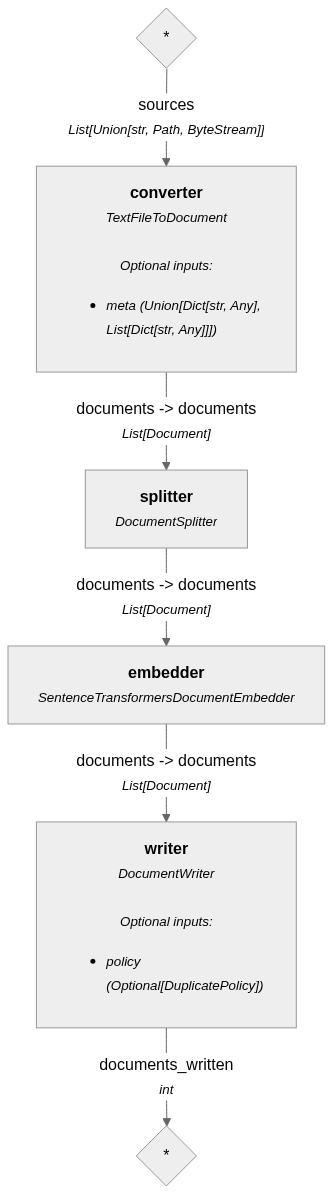

In [25]:
indexing_pipeline.show()

If we are satisfied with how we have created and connected our pipeline, we can then run it.

#### Running Pipelines


For this example, we are using the document provided by the Haystack lesson davinci.txt which has some information related to his life.

Let's try to run it.

In [10]:
indexing_pipeline.run({"converter": {"sources": ['data/davinci.txt']}})

Calculating embeddings: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


{'embedder': {'meta': {'model': 'text-embedding-ada-002-v2',
   'usage': {'prompt_tokens': 14631, 'total_tokens': 14631}}},
 'writer': {'documents_written': 47}}

In the final step of our indexing_pipeline, the **writer** component stores the documents that have been converted and vectorized into the document store. Let's take a look into the document store :

In [28]:
document_store.filter_documents()[5].content

'Leonardo\'s achievements it is necessary to\nregard him as a scientist quite as much as an artist, as a philosopher\nno less than a painter, and as a draughtsman rather than a colourist.\nThere is hardly a branch of human learning to which he did not at\none time or another give his eager attention, and he was engrossed in\nturn by the study of architecture--the foundation-stone of all true\nart--sculpture, mathematics, engineering and music. His versatility\nwas unbounded, and we are apt to regret that this many-sided genius\ndid not realise that it is by developing his power within certain\nlimits that the great master is revealed. Leonardo may be described as\nthe most Universal Genius of Christian times-perhaps of all time.\n\n[Illustration: PLATE III.-THE VIRGIN OF THE ROCKS\n\nIn the National Gallery. No. 1093. 6 ft. ½ in. h. by 3 ft 9 ½ in. w.\n(1.83 x 1.15)\n\nThis picture was painted in Milan about 1495 by Ambrogio da Predis\nunder the supervision and guidance of Leonardo da 

### Creating an searching pipeline : Searching from a document store

Similarly to what we did before, we will create now a new pipeline. This time, we will search for the documents that we have available at the document store.

In [ ]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever


query_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)

document_search = Pipeline()

document_search.add_component("query_embedder", query_embedder)
document_search.add_component("retriever", retriever)

document_search.connect("query_embedder.embedding", "retriever.query_embedding")


🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])

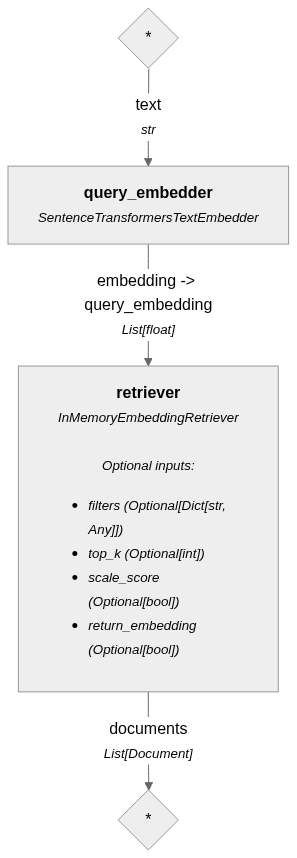

In [31]:
document_search.show()

In [15]:
question = "How old was Davinci when he died?"

results = document_search.run({"query_embedder": {"text": question},
                               "retriever": {"top_k": 3}})

for i, document in enumerate(results["retriever"]["documents"]):
    print("\n--------------\n")
    print(f"DOCUMENT {i}")
    print(document.content)


--------------

DOCUMENT 0
CHRIST, AND ST. ANNE

In the Louvre. No. 1508. 5 ft. 7 in. h. by 4 ft. 3 in. w. (1.70 x
1.29)

Painted between 1509 and 1516 with the help of assistants.]

On October 10, 1516, when he was resident at the Manor House of Cloux
near Amboise in Touraine with Francesco Melzi, his friend and
assistant, he showed three of his pictures to the Cardinal of Aragon,
but his right hand was now paralysed, and he could "no longer colour
with that sweetness with which he was wont, although still able to
make drawings and to teach others."

It was no doubt in these closing years of his life that he drew the
"Portrait of Himself" in red chalk, now at Turin, which is probably
the only authentic portrait of him in existence.



HIS DEATH

On April 23, 1519--Easter Eve--exactly forty-five years before the
birth of Shakespeare, Leonardo da Vinci made his will, and on May 2 of
the same year he passed away.

Vasari informs us that Leonardo, "having become old, lay sick for many
mo

We can try to use different top_k for the retriever. This will make the retriever fetch a specific amount of documents that given the vectorized values, can be closer to the specific query we have made before.

Chosing a good top_k value will be important in the next lesson as it will have a big impact in the performance of our Generators and our pipelines.

In [16]:
question = "Where was Davinci born?"

results = document_search.run({"query_embedder": {"text": question},
                               "retriever": {"top_k": 1}})

for i, document in enumerate(results["retriever"]["documents"]):
    print("\n--------------\n")
    print(f"DOCUMENT {i}")
    print(document.content)


--------------

DOCUMENT 0
 In the Louvre




HIS BIRTH

Leonardo Da Vinci, the many-sided genius of the Italian Renaissance,
was born, as his name implies, at the little town of Vinci, which is
about six miles from Empoli and twenty miles west of Florence. Vinci
is still very inaccessible, and the only means of conveyance is the
cart of a general carrier and postman, who sets out on his journey
from Empoli at sunrise and sunset. Outside a house in the middle of
the main street of Vinci to-day a modern and white-washed bust of the
great artist is pointed to with much pride by the inhabitants.
Leonardo's traditional birthplace on the outskirts of the town still
exists, and serves now as the headquarters of a farmer and small wine
exporter.

Leonardo di Ser Piero d'Antonio di Ser Piero di Ser Guido da
Vinci--for that was his full legal name--was the natural and
first-born son of Ser Piero, a country notary, who, like his father,
grandfather, and great-grandfather, followed that honourab